## Importing Required Packages

In [2]:
import os
from dotenv import load_dotenv
from neo4j import GraphDatabase
import pandas as pd
from datetime import datetime

# Load credentials from .env file
load_dotenv()

# Get connection details
URI = os.getenv("NEO4J_URI")
USERNAME = os.getenv("NEO4J_USERNAME")
PASSWORD = os.getenv("NEO4J_PASSWORD")

# Verify credentials loaded
print(f"URI: {URI}")
print(f"Username: {USERNAME}")
print(f"Password: {'*' * len(PASSWORD) if PASSWORD else 'NOT LOADED'}")

URI: neo4j+s://627b50dc.databases.neo4j.io
Username: neo4j
Password: *******************************************


## Checking Connectivity

In [3]:
# Create driver (do this ONCE per notebook)
driver = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))

# Test connectivity
try:
    driver.verify_connectivity()
    print("✅ Successfully connected to Neo4j AuraDB!")
    print(f"✅ Connected at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
except Exception as e:
    print(f"❌ Connection failed: {e}")
    print("\nTroubleshooting:")
    print("1. Check your .env file has correct credentials")
    print("2. Verify your AuraDB instance is 'Running' in console")
    print("3. Check URI starts with 'neo4j+s://'")

✅ Successfully connected to Neo4j AuraDB!
✅ Connected at: 2025-11-08 01:31:12


## Test Query with Neo4J

In [4]:
def run_test_query():
    """Run a simple test query"""
    query = "RETURN 1 AS number, 'Hello from AuraDB!' AS message"
    
    records, summary, keys = driver.execute_query(
        query,
        database_="neo4j"
    )
    
    # Display results
    for record in records:
        print(f"Number: {record['number']}")
        print(f"Message: {record['message']}")
    
    # Show query metadata
    print(f"\n📊 Query executed in {summary.result_available_after} ms")
    return records

# Run the test
run_test_query()

Number: 1
Message: Hello from AuraDB!

📊 Query executed in 10 ms


[<Record number=1 message='Hello from AuraDB!'>]

## DB Status

In [5]:
def get_db_stats():
    """Get current database statistics"""
    query = """
    MATCH (n)
    RETURN count(n) AS nodeCount,
           labels(n) AS labels
    """
    
    records, summary, keys = driver.execute_query(
        query,
        database_="neo4j"
    )
    
    # Count nodes
    total_nodes = sum(record['nodeCount'] for record in records)
    
    print(f"📈 Database Statistics:")
    print(f"   Total Nodes: {total_nodes}")
    
    # Count relationships
    rel_query = "MATCH ()-[r]->() RETURN count(r) AS relCount"
    rel_records, _, _ = driver.execute_query(rel_query, database_="neo4j")
    
    print(f"   Total Relationships: {rel_records[0]['relCount']}")
    
    return total_nodes

# Check stats
node_count = get_db_stats()

📈 Database Statistics:
   Total Nodes: 35
   Total Relationships: 36


## Create Simple Nodes

In [6]:
def create_sample_nodes():
    """Create sample Person nodes"""
    query = """
    CREATE (Ram:Person {name: 'Ram', age: 26, email: 'ramkumarrp16077@gmail.com'})
    CREATE (Shankar:Person {name: 'Shankar', age: 25, email: 'shankarb@gmail.com'})
    CREATE (Reyan:Person {name: 'Reyan', age: 26, email: 'befriendswithreyan@gmail.com'})
    RETURN Ram, Shankar, Reyan
    """
    
    records, summary, keys = driver.execute_query(
        query,
        database_="neo4j"
    )
    
    print("✅ Created 3 Person nodes")
    for record in records:
        for key in keys:
            node = record[key]
            print(f"   - {node['name']}, age {node['age']}")
    
    return records

# Create nodes
create_sample_nodes()

✅ Created 3 Person nodes
   - Ram, age 26
   - Shankar, age 25
   - Reyan, age 26


[<Record Ram=<Node element_id='4:56fff49d-d8e9-45b1-bd9f-0a8a54a29cad:35' labels=frozenset({'Person'}) properties={'name': 'Ram', 'age': 26, 'email': 'ramkumarrp16077@gmail.com'}> Shankar=<Node element_id='4:56fff49d-d8e9-45b1-bd9f-0a8a54a29cad:36' labels=frozenset({'Person'}) properties={'name': 'Shankar', 'age': 25, 'email': 'shankarb@gmail.com'}> Reyan=<Node element_id='4:56fff49d-d8e9-45b1-bd9f-0a8a54a29cad:37' labels=frozenset({'Person'}) properties={'name': 'Reyan', 'age': 26, 'email': 'befriendswithreyan@gmail.com'}>>]

## Create Relationship

In [7]:
def create_relationships():
    """Create KNOWS relationships between people"""
    query = """
    MATCH (Ram:Person {name: 'Shankar'})
    MATCH (Shankar:Person {name: 'Reyan'})
    MATCH (Reyan:Person {name: 'Ram'})
    
    CREATE (Ram)-[:KNOWS {since: 2016}]->(Shankar)
    CREATE (Shankar)-[:KNOWS {since: 2018}]->(Reyan)
    CREATE (Reyan)-[:KNOWS {since: 2017}]->(Ram)
    
    RETURN Ram, Shankar, Reyan
    """
    
    records, summary, keys = driver.execute_query(
        query,
        database_="neo4j"
    )
    
    print("✅ Created KNOWS relationships")
    print(f"   Query completed in {summary.result_available_after} ms")
    
    # Verify relationships
    verify_query = """
    MATCH (p1:Person)-[r:KNOWS]->(p2:Person)
    RETURN p1.name AS person1, p2.name AS person2, r.since AS since
    """
    
    verify_records, _, _ = driver.execute_query(verify_query, database_="neo4j")
    
    print("\n📊 Current relationships:")
    for record in verify_records:
        print(f"   {record['person1']} knows {record['person2']} (since {record['since']})")
    
    return verify_records

# Create relationships
create_relationships()

✅ Created KNOWS relationships
   Query completed in 27 ms

📊 Current relationships:
   Ram knows Shankar (since 2017)
   Shankar knows Reyan (since 2016)
   Reyan knows Ram (since 2018)


[<Record person1='Ram' person2='Shankar' since=2017>,
 <Record person1='Shankar' person2='Reyan' since=2016>,
 <Record person1='Reyan' person2='Ram' since=2018>]

## Search/ Filter

In [8]:
def find_person_by_name(name):
    """Find person by name using parameters (prevents injection)"""
    query = """
    MATCH (p:Person {name: $name})
    RETURN p.name AS name, p.age AS age, p.email AS email
    """
    
    records, summary, keys = driver.execute_query(
        query,
        name=name,  # Parameter binding
        database_="neo4j"
    )
    
    if records:
        person = records[0]
        print(f"👤 Found: {person['name']}")
        print(f"   Age: {person['age']}")
        print(f"   Email: {person['email']}")
    else:
        print(f"❌ Person '{name}' not found")
    
    return records

# Test parameter query
find_person_by_name("Ram")
find_person_by_name("Vishnu")  # Won't exist

👤 Found: Ram
   Age: 26
   Email: ramkumarrp16077@gmail.com
❌ Person 'Vishnu' not found


[]

## SELECT 

In [9]:
def get_all_people_as_dataframe():
    """Query all people and return as pandas DataFrame"""
    query = """
    MATCH (p:Person)
    RETURN p.name AS name, 
           p.age AS age, 
           p.email AS email
    ORDER BY p.age DESC
    """
    
    records, summary, keys = driver.execute_query(
        query,
        database_="neo4j"
    )
    
    # Convert to DataFrame
    data = [record.data() for record in records]
    df = pd.DataFrame(data)
    
    print("📊 People DataFrame:")
    print(df)
    print(f"\n   Shape: {df.shape}")
    print(f"   Average age: {df['age'].mean():.1f}")
    
    return df

# Get DataFrame
people_df = get_all_people_as_dataframe()

📊 People DataFrame:
      name   age                         email
0     None   NaN                          None
1      Ram  26.0     ramkumarrp16077@gmail.com
2    Reyan  26.0  befriendswithreyan@gmail.com
3  Shankar  25.0            shankarb@gmail.com

   Shape: (4, 3)
   Average age: 25.7


## Mutual Friends

In [10]:
def find_friends_of_friends(person_name):
    """Find friends of friends (2-hop relationships)"""
    query = """
    MATCH (person:Person {name: $name})-[:KNOWS]-(friend)-[:KNOWS]-(foaf)
    WHERE person <> foaf
    RETURN DISTINCT person.name AS person,
                    friend.name AS mutual_friend,
                    foaf.name AS friend_of_friend
    """
    
    records, summary, keys = driver.execute_query(
        query,
        name=person_name,
        database_="neo4j"
    )
    
    print(f"🔍 Friends of friends for {person_name}:")
    
    if not records:
        print("   No second-degree connections found")
        return []
    
    for record in records:
        print(f"   {record['person']} → {record['mutual_friend']} → {record['friend_of_friend']}")
    
    return records

# Find connections
find_friends_of_friends("Ram")

🔍 Friends of friends for Ram:
   Ram → Shankar → Reyan
   Ram → Reyan → Shankar


[<Record person='Ram' mutual_friend='Shankar' friend_of_friend='Reyan'>,
 <Record person='Ram' mutual_friend='Reyan' friend_of_friend='Shankar'>]

## UPDATE

In [11]:
def update_person_age(name, new_email):
    """Update a person's age"""
    query = """
    MATCH (p:Person {name: $name})
    SET p.email = $new_email
    RETURN p.name AS name, p.email AS email
    """
    
    records, summary, keys = driver.execute_query(
        query,
        name=name,
        new_email=new_email,
        database_="neo4j"
    )
    
    if records:
        person = records[0]
        print(f"✅ Updated {person['name']}'s Email to {person['email']}")
    else:
        print(f"❌ Person '{name}' not found")
    

    return records

# Update age
update_person_age("Reyan", "reyan1999@gmail.com")
find_person_by_name("Reyan")

✅ Updated Reyan's Email to reyan1999@gmail.com
👤 Found: Reyan
   Age: 26
   Email: reyan1999@gmail.com


[<Record name='Reyan' age=26 email='reyan1999@gmail.com'>]

## DELETE

In [12]:
def delete_person(name):
    """Delete a person and all their relationships"""
    query = """
    MATCH (p:Person {name: $name})
    DETACH DELETE p
    RETURN count(p) AS deleted
    """
    
    records, summary, keys = driver.execute_query(
        query,
        name=name,
        database_="neo4j"
    )
    
    deleted = records[0]['deleted']
    if deleted > 0:
        print(f"✅ Deleted {name} and all relationships")
    else:
        print(f"❌ Person '{name}' not found")
    
    return deleted

# Delete a person
delete_person("Shankar")
get_db_stats()

✅ Deleted Shankar and all relationships
📈 Database Statistics:
   Total Nodes: 37
   Total Relationships: 37


37

## Graph RAG

In [14]:
!pip uninstall -y langchain langchain-core langchain-community langchain-experimental langchain-neo4j

!pip install langchain-core==0.3.32
!pip install langchain==0.3.16
!pip install langchain-community==0.3.15
!pip install langchain-experimental==0.3.4
!pip install langchain-neo4j==0.3.0

!pip install neo4j==5.25.0 snowflake-connector-python python-dotenv networkx matplotlib


Found existing installation: langchain 1.0.2
Uninstalling langchain-1.0.2:
  Successfully uninstalled langchain-1.0.2
Found existing installation: langchain-core 1.0.1
Uninstalling langchain-core-1.0.1:
  Successfully uninstalled langchain-core-1.0.1
Found existing installation: langchain-community 0.4
Uninstalling langchain-community-0.4:
  Successfully uninstalled langchain-community-0.4
Found existing installation: langchain-experimental 0.0.42
Uninstalling langchain-experimental-0.0.42:
  Successfully uninstalled langchain-experimental-0.0.42
Found existing installation: langchain-neo4j 0.6.0
Uninstalling langchain-neo4j-0.6.0:
  Successfully uninstalled langchain-neo4j-0.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.5/633.5 kB 5.3 MB/s  0:00:00
  Attempting uninstall: zstandard
    Found existing installation: zstandard 0.25.0
    Uninstalling zstandard-0.25.0:
      Successfully uninstalled zstandard-0.25.0
  Attempting uninstall: langsmith
    Found existing installation: 

## Imports

In [13]:
import os
import json
import re
from typing import List, Dict, Tuple, Any, Optional, Mapping
from dotenv import load_dotenv

# LangChain Core
from langchain_core.language_models.llms import BaseLLM
from langchain_core.callbacks.manager import CallbackManagerForLLMRun
from langchain_core.outputs import LLMResult, Generation
from langchain_core.documents import Document

# LangChain Experimental - The REAL Graph Transformer!
from langchain_experimental.graph_transformers import LLMGraphTransformer

# Neo4j (NEW package)
from langchain_neo4j import Neo4jGraph

# Snowflake
import snowflake.connector

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

load_dotenv()
print("✅ All imports successful")

✅ All imports successful


## Connectivity Check

In [14]:
from langchain_neo4j import Neo4jGraph

# Connect to Neo4j AuraDB
graph = Neo4jGraph(
    url=os.getenv("NEO4J_URI"),
    username=os.getenv("NEO4J_USERNAME"),
    password=os.getenv("NEO4J_PASSWORD")
)

# Verify connection
print("✅ Connected to Neo4j AuraDB")

# Check current graph state
result = graph.query("MATCH (n) RETURN count(n) as node_count")
print(f"Current nodes in graph: {result[0]['node_count']}")

✅ Connected to Neo4j AuraDB
Current nodes in graph: 37


## Cortex Initialization

In [15]:
class SnowflakeCortexLLM(BaseLLM):
    """Snowflake Cortex LLM - Works with latest LangChain"""
    
    model_name: str = "mistral-large"
    
    class Config:
        """Pydantic config to allow arbitrary types"""
        arbitrary_types_allowed = True
    
    def __init__(self, model_name: str = "mistral-large", **kwargs):
        super().__init__(model_name=model_name, **kwargs)
        # Use object.__setattr__ to bypass Pydantic validation
        object.__setattr__(self, '_conn', None)
    
    def _get_connection(self):
        """Get or create Snowflake connection"""
        if self._conn is None:
            object.__setattr__(self, '_conn', snowflake.connector.connect(
                account=os.getenv("SNOWFLAKE_ACCOUNT"),
                user=os.getenv("SNOWFLAKE_USER"),
                password=os.getenv("SNOWFLAKE_PASSWORD"),
                database=os.getenv("SNOWFLAKE_DATABASE"),
                schema=os.getenv("SNOWFLAKE_SCHEMA"),
                warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
                role=os.getenv("SNOWFLAKE_ROLE")
            ))
        return self._conn
    
    @property
    def _llm_type(self) -> str:
        return "snowflake_cortex"
    
    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> LLMResult:
        """Generate responses using Snowflake Cortex"""
        generations = []
        
        for prompt in prompts:
            text = self._call_cortex(prompt)
            generations.append([Generation(text=text)])
        
        return LLMResult(generations=generations)
    
    def _call_cortex(self, prompt: str) -> str:
        """Call Snowflake Cortex COMPLETE function"""
        conn = self._get_connection()
        cursor = conn.cursor()
        
        try:
            # Escape quotes
            escaped = prompt.replace("'", "''")
            
            # Simple 2-parameter COMPLETE (most compatible)
            sql = f"SELECT SNOWFLAKE.CORTEX.COMPLETE('{self.model_name}', '{escaped}')"
            
            cursor.execute(sql)
            result = cursor.fetchone()
            return result[0] if result else ""
            
        except Exception as e:
            return f"Error: {str(e)}"
        finally:
            cursor.close()
    
    def _call(self, prompt: str, stop: Optional[List[str]] = None, **kwargs) -> str:
        """Legacy call method"""
        return self._call_cortex(prompt)
    
    def __call__(self, prompt: str) -> str:
        """Direct call support"""
        return self._call_cortex(prompt)
    
    @property
    def _identifying_params(self) -> Mapping[str, Any]:
        return {"model_name": self.model_name}
    
    def __del__(self):
        """Clean up connection"""
        try:
            if hasattr(self, '_conn') and self._conn:
                self._conn.close()
        except:
            pass


# Initialize Snowflake Cortex LLM
llm = SnowflakeCortexLLM(model_name="mistral-large")
print("✅ Snowflake Cortex LLM initialized")

# Test it
test_response = llm.invoke("Say one sentence about Knowledge Graph")
print(f"Test response: {test_response}")

✅ Snowflake Cortex LLM initialized
Test response:  A Knowledge Graph is a powerful tool for data visualization and analysis, representing interconnected descriptions of entities and their relationships in a graphical format.


In [16]:
# Sundar Pichai biography
text = """
Sundar Pichai is an Indian-American business executive who is the CEO of Alphabet Inc. 
and its subsidiary Google. Born in Madurai, Tamil Nadu, India in 1972, Pichai earned 
his degree from the Indian Institute of Technology Kharagpur in Metallurgical Engineering. 
He holds an M.S. from Stanford University in Material Sciences and Engineering, and an 
MBA from the Wharton School of the University of Pennsylvania.

Pichai joined Google in 2004, where he led the product management and innovation efforts 
for a suite of Google's client software products, including Google Chrome and Chrome OS. 
He also oversaw the development of Google Drive. On August 10, 2015, Pichai was appointed 
CEO of Google, and in December 2019, he became the CEO of Alphabet Inc., Google's parent company.

Under Pichai's leadership, Google has focused heavily on artificial intelligence and machine 
learning. He has been instrumental in the development of Google Assistant, Google Photos, 
and advancement of Google's cloud computing services. Pichai has also emphasized responsible 
AI development and has spoken about the importance of digital privacy and security.

Alphabet Inc. is headquartered in Mountain View, California. Pichai is married to Anjali Pichai, 
and they have two children. He is known for his humble leadership style and has been recognized 
as one of the most powerful people in technology. In 2020, he was awarded the Padma Bhushan, 
India's third-highest civilian award.
"""

# Create LangChain document
documents = [Document(page_content=text)]
print(f"✅ Document created ({len(text)} characters)")


✅ Document created (1480 characters)


## LLM Transformer -> Langchain

In [17]:
from langchain_experimental.graph_transformers import LLMGraphTransformer

# Initialize LangChain's LLMGraphTransformer
llm_transformer = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=[
        "Person", 
        "Organization", 
        "Location", 
        "Technology", 
        "Award", 
        "University"
    ],
    allowed_relationships=[
        "CEO_OF",
        "BORN_IN",
        "EDUCATED_AT",
        "JOINED",
        "DEVELOPED",
        "AWARDED",
        "MARRIED_TO",
        "LOCATED_IN",
        "PARENT_COMPANY_OF"
    ],
    # NOTE: Cannot use node_properties or relationship_properties with ignore_tool_usage=True
    strict_mode=True,
    ignore_tool_usage=True  # REQUIRED for Snowflake Cortex
)

print("✅ LangChain LLMGraphTransformer initialized")

✅ LangChain LLMGraphTransformer initialized


## Extract only required attributes from document

In [18]:
print("🔄 Extracting knowledge graph from text...")
print("This takes 30-60 seconds with Snowflake Cortex...\n")

# Convert documents to graph using LangChain's transformer
graph_documents = llm_transformer.convert_to_graph_documents(documents)

print(f"✅ Extraction complete!\n")

# Display results
if graph_documents and len(graph_documents) > 0:
    graph_doc = graph_documents[0]
    
    print(f"📊 Extracted Nodes: {len(graph_doc.nodes)}")
    for node in graph_doc.nodes[:10]:  # Show first 10
        props = f" {node.properties}" if hasattr(node, 'properties') and node.properties else ""
        print(f"  - {node.type}: {node.id}{props}")
    
    print(f"\n🔗 Extracted Relationships: {len(graph_doc.relationships)}")
    for rel in graph_doc.relationships[:10]:  # Show first 10
        print(f"  - ({rel.source.id})-[:{rel.type}]->({rel.target.id})")
else:
    print("⚠️ No graph data extracted")

🔄 Extracting knowledge graph from text...
This takes 30-60 seconds with Snowflake Cortex...

✅ Extraction complete!

📊 Extracted Nodes: 15
  - Person: Sundar Pichai
  - Person: Anjali Pichai
  - Technology: Google Chrome
  - Location: Madurai, Tamil Nadu, India
  - Organization: Alphabet Inc.
  - University: Wharton School of the University of Pennsylvania
  - Technology: Chrome OS
  - Technology: Google Assistant
  - Organization: Google
  - Location: Mountain View, California

🔗 Extracted Relationships: 16
  - (Sundar Pichai)-[:CEO_OF]->(Alphabet Inc.)
  - (Sundar Pichai)-[:CEO_OF]->(Google)
  - (Sundar Pichai)-[:BORN_IN]->(Madurai, Tamil Nadu, India)
  - (Sundar Pichai)-[:EDUCATED_AT]->(Indian Institute of Technology Kharagpur)
  - (Sundar Pichai)-[:EDUCATED_AT]->(Stanford University)
  - (Sundar Pichai)-[:EDUCATED_AT]->(Wharton School of the University of Pennsylvania)
  - (Sundar Pichai)-[:JOINED]->(Google)
  - (Sundar Pichai)-[:DEVELOPED]->(Google Chrome)
  - (Sundar Pichai)-[:DE

## Inserting it into AURA

In [19]:
print("\n💾 Storing knowledge graph in Neo4j AuraDB...")

# Store using LangChain's add_graph_documents
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

print("✅ Stored in Neo4j!")

# Verify
stats = graph.query("""
MATCH (n)
RETURN labels(n)[0] as type, count(n) as count
ORDER BY count DESC
""")

print("\n📊 Graph Statistics:")
for stat in stats:
    if stat['type']:
        print(f"  - {stat['type']}: {stat['count']} nodes")

rel_stats = graph.query("""
MATCH ()-[r]->()
RETURN type(r) as type, count(r) as count
ORDER BY count DESC
""")

print("\n🔗 Relationships:")
for stat in rel_stats:
    print(f"  - {stat['type']}: {stat['count']}")



💾 Storing knowledge graph in Neo4j AuraDB...
✅ Stored in Neo4j!

📊 Graph Statistics:
  - __Entity__: 49 nodes
  - Person: 2 nodes
  - User: 1 nodes
  - Document: 1 nodes

🔗 Relationships:
  - MENTIONS: 15
  - CONTAINS: 13
  - SERVES: 7
  - ATE_AT: 5
  - DEVELOPED: 5
  - TRIED: 4
  - PREFERS: 3
  - EDUCATED_AT: 3
  - LOCATED_IN: 2
  - CEO_OF: 2
  - HAS_CUISINE: 1
  - VISITED: 1
  - HAS_PROPERTY: 1
  - KNOWS: 1
  - BORN_IN: 1
  - JOINED: 1
  - MARRIED_TO: 1
  - AWARDED: 1
  - PARENT_COMPANY_OF: 1


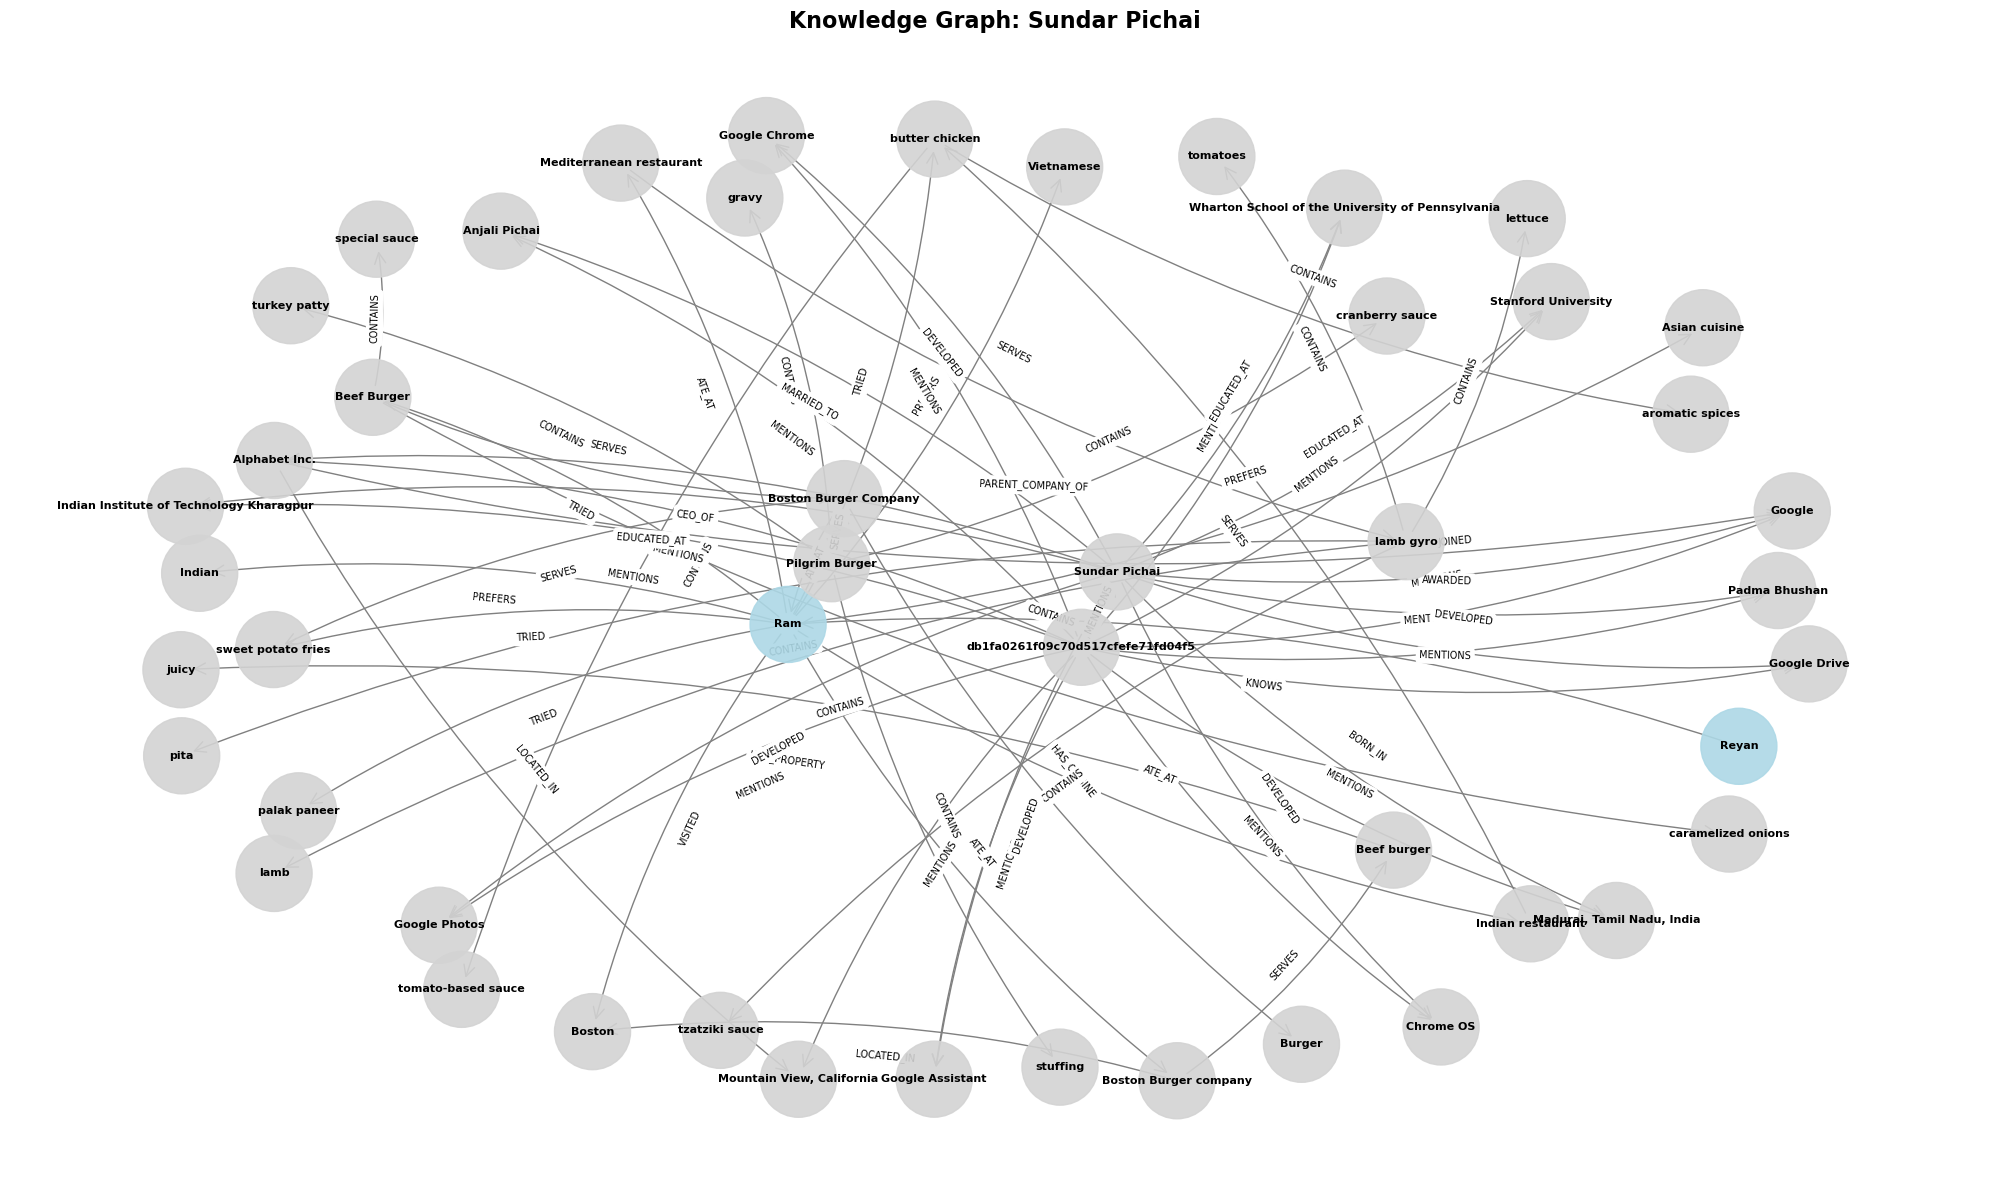


📈 Graph: 48 nodes, 67 edges


In [21]:
def visualize_graph():
    """Visualize the knowledge graph"""
    
    # Query graph structure - use properties that actually exist
    query_result = graph.query("""
    MATCH (n)-[r]->(m)
    RETURN coalesce(n.id, n.name, 'Unknown') as source, 
           type(r) as relationship, 
           coalesce(m.id, m.name, 'Unknown') as target, 
           labels(n)[0] as source_type, 
           labels(m)[0] as target_type
    LIMIT 100
    """)
    
    if not query_result:
        print("⚠️ No graph data to visualize. Run the extraction first!")
        return
    
    # Build NetworkX graph
    G = nx.DiGraph()
    
    for record in query_result:
        source = record['source']
        target = record['target']
        
        # Skip if None
        if source and target:
            G.add_node(source, node_type=record['source_type'])
            G.add_node(target, node_type=record['target_type'])
            G.add_edge(source, target, relationship=record['relationship'])
    
    if G.number_of_nodes() == 0:
        print("⚠️ No nodes found in graph")
        return
    
    # Color map
    color_map = {
        'Person': 'lightblue',
        'Organization': 'lightgreen',
        'Location': 'lightyellow',
        'University': 'lightcoral',
        'Technology': 'lightpink',
        'Award': 'orange'
    }
    
    node_colors = [color_map.get(G.nodes[node].get('node_type', 'Unknown'), 'lightgray') for node in G.nodes()]
    
    # Draw
    plt.figure(figsize=(20, 12))
    pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                           arrowsize=20, arrowstyle='->', connectionstyle='arc3,rad=0.1')
    
    edge_labels = nx.get_edge_attributes(G, 'relationship')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7)
    
    plt.title("Knowledge Graph: Sundar Pichai", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

visualize_graph()


In [22]:
class GraphRAGRetriever:
    """Retrieve context from knowledge graph for RAG"""
    
    def __init__(self, graph: Neo4jGraph, llm):
        self.graph = graph
        self.llm = llm
    
    def retrieve(self, question: str) -> str:
        """Retrieve relevant context from graph"""
        
        # Extract entities from question
        import re
        entities = re.findall(r'\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\b', question)
        
        if not entities:
            entities = [question.split()[0]]
        
        context_parts = []
        
        # Get graph context for each entity
        for entity in entities[:3]:
            result = self.graph.query("""
            MATCH (e)-[r]->(target)
            WHERE coalesce(e.id, e.name) = $entity
            RETURN coalesce(e.id, e.name) as entity, 
                   type(r) as relationship, 
                   coalesce(target.id, target.name) as target, 
                   labels(target)[0] as type
            LIMIT 5
            """, params={"entity": entity})
            
            if result:
                context_parts.append(f"\n{entity}:")
                for record in result:
                    context_parts.append(
                        f"  - {record['relationship']}: {record['target']} ({record['type']})"
                    )
        
        # Fuzzy search if no exact match
        if not context_parts:
            keyword = entities[0] if entities else question.split()[0]
            result = self.graph.query("""
            MATCH (n)-[r]->(m)
            WHERE toLower(coalesce(n.id, n.name, '')) CONTAINS toLower($keyword)
               OR toLower(coalesce(m.id, m.name, '')) CONTAINS toLower($keyword)
            RETURN coalesce(n.id, n.name) as source, 
                   type(r) as relationship, 
                   coalesce(m.id, m.name) as target
            LIMIT 10
            """, params={"keyword": keyword})
            
            if result:
                context_parts.append("\nRelevant information:")
                for record in result:
                    context_parts.append(
                        f"  - {record['source']} {record['relationship']} {record['target']}"
                    )
        
        return "\n".join(context_parts) if context_parts else "No relevant information found."
    
    def ask(self, question: str) -> str:
        """Answer question using GraphRAG"""
        
        print(f"\n{'='*60}")
        print(f"❓ Question: {question}")
        print(f"{'='*60}")
        
        # Retrieve context
        print("\n🔍 Retrieving from knowledge graph...")
        context = self.retrieve(question)
        print(f"{context}")
        
        # Generate answer
        print("\n💭 Generating answer...")
        prompt = f"""Use the following knowledge graph information to answer the question.

Knowledge Graph Context:
{context}

Question: {question}

Provide a clear answer based on the graph information above.

Answer:"""
        
        answer = self.llm.invoke(prompt)
        print(f"\n✅ Answer:\n{answer}\n")
        
        return answer


# Initialize GraphRAG
retriever = GraphRAGRetriever(graph=graph, llm=llm)


In [23]:
questions = [
    "Where was Sundar Pichai born?",
    "Where does Sundar Pichai work?"
]

for question in questions:
    answer = retriever.ask(question)
    print("\n" + "-"*60 + "\n")


❓ Question: Where was Sundar Pichai born?

🔍 Retrieving from knowledge graph...

Sundar Pichai:
  - CEO_OF: Alphabet Inc. (__Entity__)
  - CEO_OF: Google (__Entity__)
  - BORN_IN: Madurai, Tamil Nadu, India (__Entity__)
  - EDUCATED_AT: Wharton School of the University of Pennsylvania (__Entity__)
  - EDUCATED_AT: Stanford University (__Entity__)

💭 Generating answer...

✅ Answer:
 Sundar Pichai was born in Madurai, Tamil Nadu, India.


------------------------------------------------------------


❓ Question: Where does Sundar Pichai work?

🔍 Retrieving from knowledge graph...

Sundar Pichai:
  - CEO_OF: Alphabet Inc. (__Entity__)
  - CEO_OF: Google (__Entity__)
  - BORN_IN: Madurai, Tamil Nadu, India (__Entity__)
  - EDUCATED_AT: Wharton School of the University of Pennsylvania (__Entity__)
  - EDUCATED_AT: Stanford University (__Entity__)

💭 Generating answer...

✅ Answer:
 Sundar Pichai works at Alphabet Inc. and Google. He is the CEO of both these companies.


-------------------

In [13]:
from langchain_experimental.graph_transformers import LLMGraphTransformer

# Initialize LLMGraphTransformer with Snowflake Cortex
# Using ignore_tool_usage=True for prompt-based extraction
llm_transformer = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Person", "Organization", "Location", "Technology", "Award", "University"],
    allowed_relationships=[
        "CEO_OF", 
        "BORN_IN", 
        "EDUCATED_AT", 
        "JOINED", 
        "DEVELOPED",
        "AWARDED",
        "MARRIED_TO",
        "LOCATED_IN",
        "PARENT_COMPANY_OF"
    ],
    node_properties=["year", "degree", "position"],
    strict_mode=True,
    ignore_tool_usage=True  # CRITICAL for Snowflake Cortex
)

print("✅ LLMGraphTransformer initialized with Snowflake Cortex")

ModuleNotFoundError: No module named 'langchain.graphs'